# CNN sur classification manuelle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# code pour préparer X et y

In [ ]:
df1 = pd.read_csv("dataset_500Hz_1.csv")
df2 = pd.read_csv("dataset_500Hz_2.csv")
df3 = pd.read_csv("dataset_500Hz_3.csv")
df4 = pd.read_csv("dataset_500Hz_4.csv")

In [ ]:
df2.shape

(1350000, 3)

In [ ]:
# --- CONFIGURATION ---
filenames = [f"dataset_500Hz_{i}.csv" for i in range(1, 6)] # Génère la liste des 5 fichiers
FS = 500
WINDOW_SIZE = FS * 1

all_X = []
all_y_raw = []

# --- CHARGEMENT ET PRÉ-TRAITEMENT ---
for f in filenames:
    print(f"Traitement de {f}...")
    df = pd.read_csv(f)

    # Calcul du nombre de fenêtres complètes
    num_samples = len(df) // WINDOW_SIZE
    limit = num_samples * WINDOW_SIZE
    df_clean = df.iloc[:limit]

    # Extraction et reshape
    X_file = df_clean[['hpc_500', 'pfc_500']].values
    X_file = X_file.reshape(num_samples, WINDOW_SIZE, 2)

    # Extraction des labels (1er de chaque bloc)
    y_file = df_clean['manual_500'].values[::WINDOW_SIZE]

    all_X.append(X_file)
    all_y_raw.append(y_file)

# --- CONCATÉNATION FINALE ---
# On transforme les listes en un seul gros bloc NumPy
X = np.concatenate(all_X, axis=0)
y_raw = np.concatenate(all_y_raw, axis=0)

print(f"\nFusion terminée !")
print(f"Format total X : {X.shape}") # Devrait être (Somme_des_N, 500, 2)
print(f"Format total y : {y_raw.shape}")

Traitement de dataset_500Hz_1.csv...
Traitement de dataset_500Hz_2.csv...
Traitement de dataset_500Hz_3.csv...
Traitement de dataset_500Hz_4.csv...
Traitement de dataset_500Hz_5.csv...

Fusion terminée !
Format total X : (13542, 500, 2)
Format total y : (13542,)


# 5. Encodage des labels (Gestion du 0, 1, 3, 4, 5)

In [ ]:
# 1. On utilise y_raw (qui contient déjà les labels des 5 fichiers fusionnés)
le = LabelEncoder()
y = le.fit_transform(y_raw)
CLASSES_ORIGINALES = le.classes_
NUM_CLASSES = len(CLASSES_ORIGINALES)

print(f"Format final de X (tous fichiers) : {X.shape}")
print(f"Format final de y (tous fichiers) : {y.shape}")
print(f"Labels détectés sur l'ensemble : {CLASSES_ORIGINALES}")

Format final de X (tous fichiers) : (13542, 500, 2)
Format final de y (tous fichiers) : (13542,)
Labels détectés sur l'ensemble : [0 1 3 4 5]


# 6. Split Train / Test (80% entrainement, 20% validation)

In [ ]:
# 'stratify=y' assure qu'on a la même proportion de sommeil/éveil dans les deux sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Chemin de sauvegarde

In [ ]:
# Le fichier .keras est le format moderne recommandé par TensorFlow
checkpoint_path = "meilleur_cnn_cerveau.keras"

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',   # Surveiller la perte plutôt que la précision
    save_best_only=True,
    mode='min',           # On veut la perte la plus basse possible
    verbose=1
)

# modèle

In [ ]:
def build_brain_cnn(input_shape, num_classes):
    model = models.Sequential()

    # Bloc 1
    model.add(layers.Conv1D(16, 10, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    # Bloc 2
    model.add(layers.Conv1D(32, 5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    # Bloc 3
    model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(2))

    # Classification
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_brain_cnn((WINDOW_SIZE, 2), NUM_CLASSES)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
# Batch_size = 32 : Le réseau regarde 32 secondes de signal avant de se mettre à jour
# 4. On relance l'entraînement avec les callbacks
print("Lancement de l'entraînement...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb]
)

Lancement de l'entraînement...
Epoch 1/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6036 - loss: 0.9742
Epoch 1: val_loss improved from inf to 0.79806, saving model to meilleur_cnn_cerveau.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6038 - loss: 0.9737 - val_accuracy: 0.7036 - val_loss: 0.7981
Epoch 2/20
334/339 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.6702
Epoch 2: val_loss improved from 0.79806 to 0.60600, saving model to meilleur_cnn_cerveau.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7555 - loss: 0.6698 - val_accuracy: 0.7929 - val_loss: 0.6060
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7932 - loss: 0.5670
Epoch 3: val_loss improved from 0.60600 to 0.53532, saving model to meilleur_cnn_cerveau.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7932 - loss: 0.5671 - val_accuracy: 0.8154 - val_loss: 0.5353
Epoch 4/20
338/339 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8107 - los

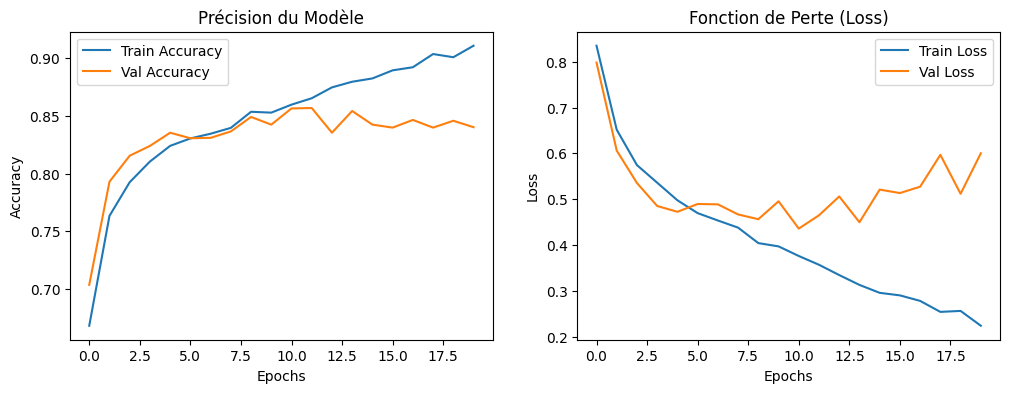

In [ ]:
# --- VISUALISATION ---

plt.figure(figsize=(12, 4))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Précision du Modèle')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Fonction de Perte (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# visualisation

Chargement du meilleur modèle sauvegardé...
Calcul des prédictions sur le jeu de test...
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


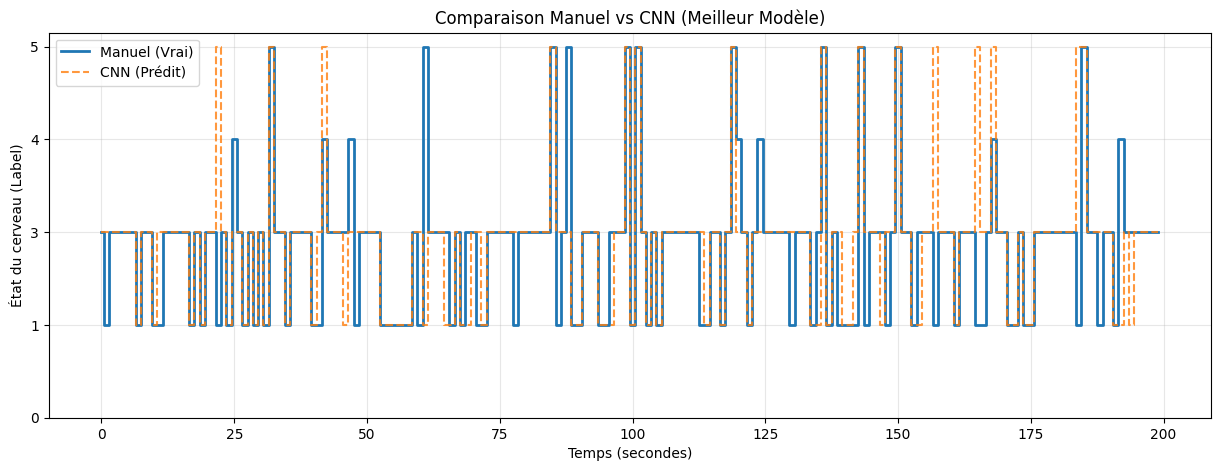


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.73      0.81       811
           3       0.86      0.96      0.91      1607
           4       0.17      0.01      0.02        78
           5       0.75      0.83      0.79       211

    accuracy                           0.86      2709
   macro avg       0.54      0.51      0.51      2709
weighted avg       0.84      0.86      0.84      2709



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 1. On charge le MEILLEUR modèle sauvegardé par le checkpoint
# (Sinon on utilise le modèle de l'époque 20 qui est peut-être moins bon)
print("Chargement du meilleur modèle sauvegardé...")
best_model = tf.keras.models.load_model("meilleur_cnn_cerveau.keras")

# 2. On calcule les prédictions (C'est la ligne qui manquait !)
print("Calcul des prédictions sur le jeu de test...")
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # On prend l'index de la proba max

# 3. Affichage de l'Hypnogramme comparatif
limit_plot = 200
y_test_sample = y_test[:limit_plot]
y_pred_sample = y_pred[:limit_plot]

time_axis = np.arange(limit_plot)

plt.figure(figsize=(15, 5))

# On décale légèrement les courbes pour qu'elles ne se superposent pas totalement
plt.step(time_axis, y_test_sample, where='mid', label='Manuel (Vrai)', linewidth=2)
plt.step(time_axis, y_pred_sample, where='mid', label='CNN (Prédit)', linestyle='--', alpha=0.8)

# Remettre les vrais labels sur l'axe Y
plt.yticks(range(NUM_CLASSES), CLASSES_ORIGINALES)
plt.xlabel('Temps (secondes)')
plt.ylabel('État du cerveau (Label)')
plt.title('Comparaison Manuel vs CNN (Meilleur Modèle)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Petit rapport textuel pour confirmer la performance
print("\n--- RAPPORT DE CLASSIFICATION ---")
# On génère la liste des indices attendus : [0, 1, 2, 3, 4]
labels_indices = np.arange(len(CLASSES_ORIGINALES))

print(classification_report(y_test, y_pred,
                            labels=labels_indices, # On force l'affichage des 5 classes
                            target_names=[str(c) for c in CLASSES_ORIGINALES]))